# Chatbot with Long-Term Memory(LTM) and STM

## Long term memory (LTM)
- LTM is used for storing inter session information - eg: User preferences, profile, etc.
- Types: 
  - Semantic memory - Eg: profile info, 
  - Episodic memory - Eg: Previous agent actions
  - Procedural memory - Eg: System instructions
- **LG concept**: `Store`

## STM 
- thread wide memory like history of conversations
- **LG concept**: `Checkpointers and config`


## Introduction to the LangGraph Store

The [LangGraph Memory Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) provides a way to store and retrieve information *across threads* in LangGraph.

This is an  [open source base class](https://blog.langchain.dev/launching-long-term-memory-support-in-langgraph/) for persistent `key-value` stores.

In [1]:
from dotenv import load_dotenv
load_dotenv()
import uuid
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

### store setup

In [2]:
user_id = "1"
namespace_for_memory = (user_id, "memories")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())

# The value needs to be a dictionary  
value = {"food_preference" : "I like biryani"}

# Save the memory
in_memory_store.put(namespace_for_memory, key, value)

We use [search](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.search) to retrieve objects from the store by `namespace`.

This returns a list.

In [6]:
# Search 
memories = in_memory_store.search(namespace_for_memory)
memories # list

[Item(namespace=['1', 'memories'], key='828bb111-3408-4504-9322-b45ab4391497', value={'food_preference': 'I like biryani'}, created_at='2025-07-30T02:10:08.631571+00:00', updated_at='2025-07-30T02:10:08.631573+00:00', score=None)]

We can also use [get](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.get) to retrieve an object by `namespace` and `key`.

In [3]:
# Get the memory by namespace and key
memory = in_memory_store.get(namespace_for_memory, key)
memory.dict()

{'namespace': ['1', 'memories'],
 'key': 'fb601ebe-313c-4c44-8d64-49ba04193109',
 'value': {'food_preference': 'I like biryani'},
 'created_at': '2025-07-30T02:52:45.352775+00:00',
 'updated_at': '2025-07-30T02:52:45.352777+00:00'}

### Adding LTM to chatbot

In [85]:
from langchain_google_genai import ChatGoogleGenerativeAI


llm = ChatGoogleGenerativeAI(model='gemini-2.5-pro',temperature=0)

In [91]:
LTM_SYS_INSTRUCTION = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

CREATE_MEMORY_INSTRUCTION = """You are collecting information about the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history below carefully
2. Identify new information about the user, such as:
    - Personal details (name, location)
    - Preferences (likes, dislikes)
    - Interests and hobbies
    - Past experiences
    - Goals or future plans
    - Keep adding attributes to the profile as you discover things
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: 
1. The goal is to create/update user profile information and not to answer the questions based on chat history.
2. Only include factual information directly stated by the user. Do not make assumptions or inferences.

Example Output: "**User Information:**\n- User's name is Bob.\n- Likes to code and bike around San Francisco."

please update the user information based on the chat history:
"""

In [92]:
from pydantic import BaseModel, Field

class Memory(BaseModel):
    memory: str = Field(description='The updated memory for the user profile')

### nodes

In [96]:
from langgraph.store.base import BaseStore
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig

def invoke_llm_node(state: MessagesState, config: RunnableConfig, store: BaseStore) -> dict:

    user_id = config["configurable"]["user_id"]
    namespace = ("memory", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)

    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No memory found."

    system_msg = LTM_SYS_INSTRUCTION.format(memory=existing_memory_content)
    
    response = llm.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def update_memory_node(state: MessagesState, config: RunnableConfig, store: BaseStore) -> None:
    print('🧠 Updating Memory...')
    user_id = config["configurable"]["user_id"]

    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
    print('exising mem: ', existing_memory)   
    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        print('No mem')
        existing_memory_content = "No existing memory found."
    llm_with_st_op = llm.with_structured_output(Memory)
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content)
    new_memory = llm_with_st_op.invoke([SystemMessage(content=system_msg)]+state['messages'])
    # Update existing memory in the store 
    key = "user_memory"
    store.put(namespace, key, {"memory": new_memory.memory})

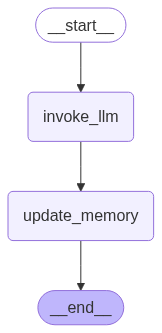

In [97]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END

builder = StateGraph(MessagesState)
builder.add_node("invoke_llm", invoke_llm_node)
builder.add_node("update_memory", update_memory_node)
builder.add_edge(START, "invoke_llm")
builder.add_edge("invoke_llm", "update_memory")
builder.add_edge("update_memory", END)

ltm = InMemoryStore() # long term memory - pertained across threads

stm = MemorySaver() # short term memory - used to pause, resume and for thread wide context

graph = builder.compile(checkpointer=stm, store=ltm)

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [98]:
config = {"configurable": {"thread_id": "1", "user_id": "1"}} # thread_id for stm; user_id for ltm

input_messages = [HumanMessage(content="Hi, my name is Alice")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Alice
================================== Ai Message ==================================

Hi Alice! It's nice to meet you.

I'll remember your name for our future conversations. How can I help you today?
🧠 Updating Memory...
exising mem:  None
No mem


#### peek memory 👀

In [99]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = ltm.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'memory': "- User's name is Alice."},
 'created_at': '2025-07-30T03:30:22.845274+00:00',
 'updated_at': '2025-07-30T03:30:22.845278+00:00'}

In [100]:
# User input 
input_messages = [HumanMessage(content="I like to camp around upstate")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to camp around upstate
================================== Ai Message ==================================

That's great to know, Alice! Camping upstate is a fantastic way to connect with nature. I'll add that to my memory so I can give you better recommendations in the future.

When you say "upstate," which state are you usually referring to? Upstate New York is a popular destination, but many states have an "upstate" region.

Knowing that, I can help you find new campgrounds, suggest hiking trails, or check the weather for your trips. Do you have any favorite spots you've been to?
🧠 Updating Memory...
exising mem:  Item(namespace=['memory', '1'], key='user_memory', value={'memory': "- User's name is Alice."}, created_at='2025-07-30T03:30:22.845274+00:00', updated_at='2025-07-30T03:30:22.845278+00:00')


We're using the `MemorySaver` checkpointer for within-thread memory.

This saves the chat history to the thread.

We can look at the chat history saved to the thread.

In [101]:
thread = {"configurable": {"thread_id": "1"}}
state = graph.get_state(thread).values
for m in state["messages"]: 
    m.pretty_print()

================================ Human Message =================================

Hi, my name is Alice
================================== Ai Message ==================================

Hi Alice! It's nice to meet you.

I'll remember your name for our future conversations. How can I help you today?
================================ Human Message =================================

I like to camp around upstate
================================== Ai Message ==================================

That's great to know, Alice! Camping upstate is a fantastic way to connect with nature. I'll add that to my memory so I can give you better recommendations in the future.

When you say "upstate," which state are you usually referring to? Upstate New York is a popular destination, but many states have an "upstate" region.

Knowing that, I can help you find new campgrounds, suggest hiking trails, or check the weather for your trips. Do you have any favorite spots you've been to?


In [102]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = ltm.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'memory': "- User's name is Alice.\n- Likes to camp around upstate."},
 'created_at': '2025-07-30T03:30:44.480316+00:00',
 'updated_at': '2025-07-30T03:30:44.480326+00:00'}

Now, let's kick off a *new thread* with the *same user ID*.

We should see that the chatbot remembered the user's profile and used it to personalize the response.

In [103]:
# We supply a user ID for across-thread memory as well as a new thread ID
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi! Where would you recommend that I go camping?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! Where would you recommend that I go camping?
================================== Ai Message ==================================

Hi Alice! It's great to hear from you.

Since I know you enjoy camping around upstate, I have a few recommendations that you might love, depending on the kind of vibe you're looking for:

**1. For a classic Adirondacks experience: Fish Creek Pond Campground**
This is one of the most popular spots for a reason. Nearly every site is on the water, making it perfect for kayaking, canoeing, or just relaxing by the shore. It's very well-equipped and great for both families and groups of friends.

**2. For stunning gorges and waterfalls: Watkins Glen State Park**
Located in the Finger Lakes region, this park is famous for its incredible gorge trail that takes you past 19 waterfalls. It's a truly magical hike. The campground is lovely and gives you easy access to the gorge and the nea

In [104]:
# User input 
input_messages = [HumanMessage(content="Great, are there any good spots to dine nearby, to feel the smack")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Great, are there any good spots to dine nearby, to feel the smack
================================== Ai Message ==================================

Absolutely, Alice! Finding a spot with food that really hits the spot—or "feels the smack"—after a day of camping is one of the best parts of the trip.

Here are some fantastic dining options near the campgrounds we talked about, perfect for satisfying a post-hike appetite:

**1. Near Fish Creek Pond (Saranac Lake / Tupper Lake Area):**

*   **For a Hearty Meal & Great Beer:** **Raquette River Brewing** (Tupper Lake). This is a classic Adirondack stop. They have a fantastic selection of craft beers and usually have a food truck on-site serving up delicious, no-fuss food like wood-fired pizza or gourmet tacos. The vibe is super relaxed and perfect for campers.
*   **For a Cozy Cafe Vibe:** **The Blue Moon Cafe** (Saranac Lake). A beloved local spot known for it

#### peek memory 👀

In [105]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = ltm.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'memory': '- User\'s name is Alice.\n- Likes to camp around upstate.\n- Appreciates flavorful and satisfying food (uses the phrase "feel the smack").'},
 'created_at': '2025-07-30T03:34:04.615766+00:00',
 'updated_at': '2025-07-30T03:34:04.615771+00:00'}